In [19]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/root/.cache/kagglehub/datasets/kritikseth/fruit-and-vegetable-image-recognition/versions/8'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/root/.cache/kagglehub/datasets/kritikseth/fruit-and-vegetable-image-recognition/versions/8/test/paprika/Image_2.jpg
/root/.cache/kagglehub/datasets/kritikseth/fruit-and-vegetable-image-recognition/versions/8/test/paprika/Image_10.jpg
/root/.cache/kagglehub/datasets/kritikseth/fruit-and-vegetable-image-recognition/versions/8/test/paprika/Image_9.jpg
/root/.cache/kagglehub/datasets/kritikseth/fruit-and-vegetable-image-recognition/versions/8/test/paprika/Image_7.jpg
/root/.cache/kagglehub/datasets/kritikseth/fruit-and-vegetable-image-recognition/versions/8/test/paprika/Image_4.jpg
/root/.cache/kagglehub/datasets/kritikseth/fruit-and-vegetable-image-recognition/versions/8/test/paprika/Image_3.jpg
/root/.cache/kagglehub/datasets/kritikseth/fruit-and-vegetable-image-recognition/versions/8/test/paprika/Image_8.jpg
/root/.cache/kagglehub/datasets/kritikseth/fruit-and-vegetable-image-recognition/versions/8/test/paprika/Image_1.jpg
/root/.cache/kagglehub/datasets/kritikseth/fruit-and-vegetable-

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kritikseth/fruit-and-vegetable-image-recognition")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/kritikseth/fruit-and-vegetable-image-recognition/versions/8


In [4]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,img_to_array
print(tf.__version__)

2.17.1


In [5]:
# Create a list with the filepaths for training and testing
train_dir = Path('../root/.cache/kagglehub/datasets/kritikseth/fruit-and-vegetable-image-recognition/versions/8/train')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

In [6]:
test_dir = Path('../root/.cache/kagglehub/datasets/kritikseth/fruit-and-vegetable-image-recognition/versions/8/test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

In [7]:
val_dir = Path('../root/.cache/kagglehub/datasets/kritikseth/fruit-and-vegetable-image-recognition/versions/8/validation')
val_filepaths = list(test_dir.glob(r'**/*.jpg'))

In [8]:
def image_processing(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)

    return df

In [9]:
train_df = image_processing(train_filepaths)
test_df = image_processing(test_filepaths)
val_df = image_processing(val_filepaths)

In [10]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 2780

Number of different labels: 36

Labels: ['turnip' 'soy beans' 'corn' 'grapes' 'ginger' 'onion' 'pineapple'
 'banana' 'tomato' 'beetroot' 'lettuce' 'jalepeno' 'pear' 'kiwi'
 'pomegranate' 'mango' 'cabbage' 'spinach' 'carrot' 'watermelon' 'paprika'
 'peas' 'cucumber' 'eggplant' 'sweetpotato' 'lemon' 'capsicum' 'apple'
 'raddish' 'orange' 'potato' 'garlic' 'bell pepper' 'sweetcorn'
 'cauliflower' 'chilli pepper']


In [11]:
train_df.head(5)

,Filepath,Label
0,../root/.cache/kagglehub/datasets/kritikseth/f...,turnip
1,../root/.cache/kagglehub/datasets/kritikseth/f...,soy beans
2,../root/.cache/kagglehub/datasets/kritikseth/f...,corn
3,../root/.cache/kagglehub/datasets/kritikseth/f...,grapes
4,../root/.cache/kagglehub/datasets/kritikseth/f...,ginger


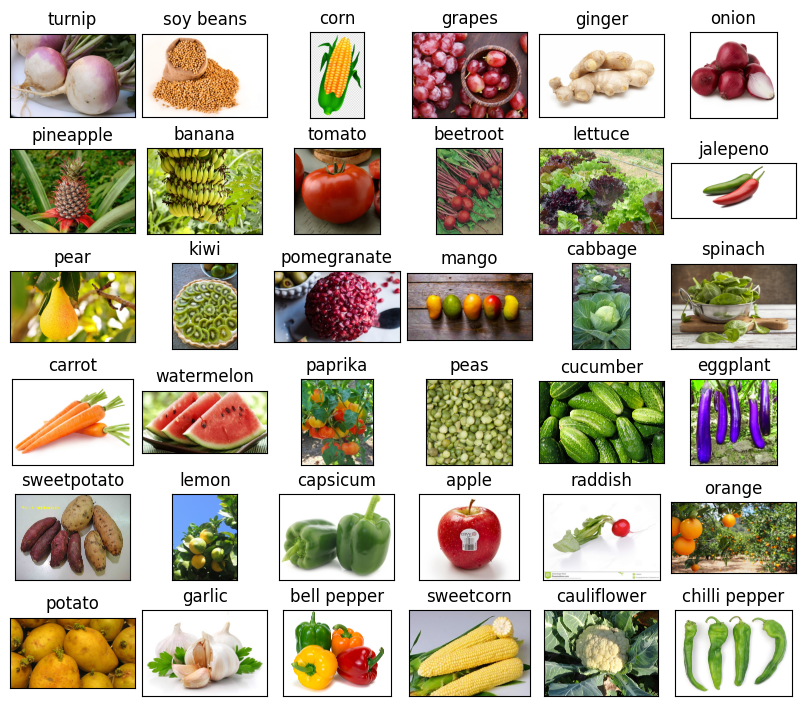

In [12]:
# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [13]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [14]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 2780 validated image filenames belonging to 36 classes.


In [15]:
val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 334 validated image filenames belonging to 36 classes.


In [16]:
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 334 validated image filenames belonging to 36 classes.


In [17]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [18]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(36, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


87/87 ━━━━━━━━━━━━━━━━━━━━ 217s 2s/step - accuracy: 0.3410 - loss: 2.5674 - val_accuracy: 0.8503 - val_loss: 0.4854
Epoch 2/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 272s 2s/step - accuracy: 0.8195 - loss: 0.5827 - val_accuracy: 0.9162 - val_loss: 0.3133
Epoch 3/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 243s 2s/step - accuracy: 0.8994 - loss: 0.3323 - val_accuracy: 0.9162 - val_loss: 0.2491
Epoch 4/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.9379 - loss: 0.2079 - val_accuracy: 0.9461 - val_loss: 0.2074
Epoch 5/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 208s 2s/step - accuracy: 0.9450 - loss: 0.1714 - val_accuracy: 0.9431 - val_loss: 0.2114


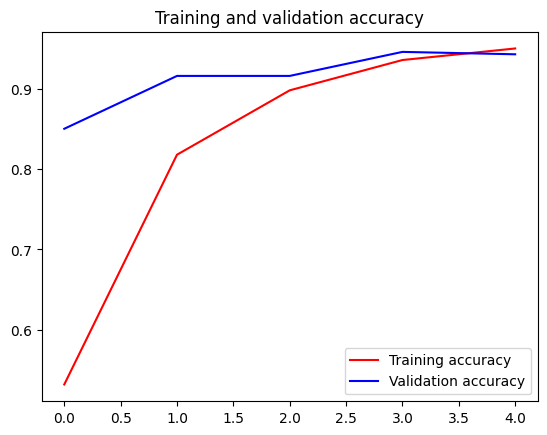

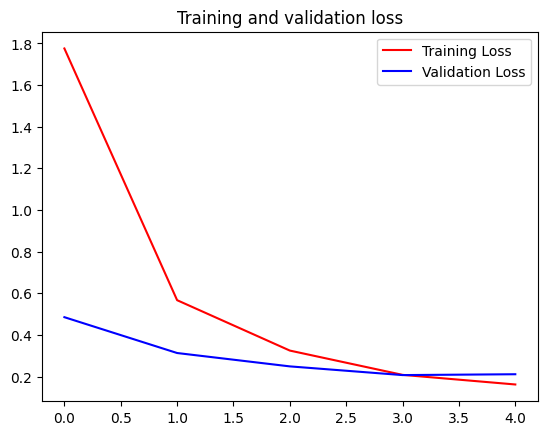

In [20]:
# prompt: make a code to check the grapich of epoch for this model.

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [21]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)
# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred1 = [labels[k] for k in pred]
pred1

11/11 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step


['orange',
 'carrot',
 'lettuce',
 'cucumber',
 'raddish',
 'cabbage',
 'banana',
 'carrot',
 'garlic',
 'capsicum',
 'cabbage',
 'bell pepper',
 'mango',
 'pineapple',
 'kiwi',
 'beetroot',
 'onion',
 'bell pepper',
 'bell pepper',
 'paprika',
 'eggplant',
 'pomegranate',
 'lettuce',
 'banana',
 'mango',
 'orange',
 'jalepeno',
 'sweetcorn',
 'banana',
 'jalepeno',
 'carrot',
 'corn',
 'paprika',
 'ginger',
 'bell pepper',
 'sweetcorn',
 'soy beans',
 'spinach',
 'mango',
 'jalepeno',
 'eggplant',
 'watermelon',
 'eggplant',
 'pineapple',
 'pineapple',
 'onion',
 'bell pepper',
 'capsicum',
 'pear',
 'paprika',
 'pomegranate',
 'corn',
 'pomegranate',
 'cabbage',
 'paprika',
 'paprika',
 'grapes',
 'cucumber',
 'cabbage',
 'bell pepper',
 'cauliflower',
 'sweetcorn',
 'raddish',
 'lemon',
 'cauliflower',
 'sweetpotato',
 'mango',
 'sweetcorn',
 'garlic',
 'watermelon',
 'cucumber',
 'potato',
 'paprika',
 'soy beans',
 'pomegranate',
 'chilli pepper',
 'lettuce',
 'sweetpotato',
 'bee

In [22]:
def output(location):
    img=load_img(location,target_size=(224,224,3))
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    answer=model.predict(img)
    y_class = answer.argmax(axis=-1)
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = labels[y]
    return res

In [23]:
img = output('../root/.cache/kagglehub/datasets/kritikseth/fruit-and-vegetable-image-recognition/versions/8/test/cabbage/Image_1.jpg')
img

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


'cabbage'

In [24]:
model.save('FV.h5')